In [66]:
! pip uninstall -y -q tensorflow
! pip install -q tensorflow-gpu==2.8.0
! pip install -q deepmatch

## loss: 0.0122 - mse: 0.0121 - accuracy: 0.9847  
## - val_loss: 0.1333 - val_mse: 0.1332 - val_accuracy: 0.8544

# DeepFM with features as Sparse features including:
* []

In [429]:
import pandas as pd
import numpy as np
import sklearn

In [430]:
df_org = pd.read_csv('/content/ad_10000records.csv')
df = df_org
df.head(2)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0


In [431]:
df = df.rename(columns = {'Daily Time Spent on Site':'daily_time_on_site',
                          'Daily Internet Usage':'Daily_Internet_Usage',
                          'Area Income':'Area_Income',
                          'Ad Topic Line':'Ad_Topic_Line',
                          'Clicked on Ad':'Clicked_on_Ad'})
df.head(2)

,daily_time_on_site,Age,Area_Income,Daily_Internet_Usage,Ad_Topic_Line,City,Gender,Country,Timestamp,Clicked_on_Ad
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0


In [432]:
df['daily_time_on_site'] = df['daily_time_on_site'].astype(float)
df['Daily_Internet_Usage'] = df['Daily_Internet_Usage'].astype(float)
df['Area_Income'] = df['Area_Income'].astype(float)
df['Ad_Topic_Line'] = df['Ad_Topic_Line'].astype(str)
df['Clicked_on_Ad'] = df['Clicked_on_Ad'].astype(int)
df['Country'] = df['Country'].astype(str)
df['City'] = df['City'].astype(str)

In [433]:
# getting sparse features
numerical_features = ['daily_time_on_site','Age', 'Area_Income', 'Daily_Internet_Usage']
sparse_features = ['Ad_Topic_Line', 'City', 'Gender', 'Country']
target = ['Clicked_on_Ad']

<Axes: title={'center': 'Daily Time Spent on Site'}, ylabel='Frequency'>

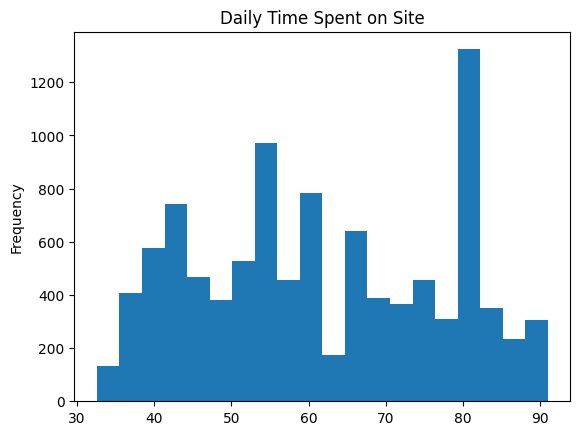

In [434]:
from matplotlib import pyplot as plt
df['daily_time_on_site'].plot(kind='hist', bins=20, title='Daily Time Spent on Site')


In [435]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   daily_time_on_site    10000 non-null  float64
 1   Age                   10000 non-null  float64
 2   Area_Income           10000 non-null  float64
 3   Daily_Internet_Usage  10000 non-null  float64
 4   Ad_Topic_Line         10000 non-null  object 
 5   City                  10000 non-null  object 
 6   Gender                10000 non-null  object 
 7   Country               10000 non-null  object 
 8   Timestamp             10000 non-null  object 
 9   Clicked_on_Ad         10000 non-null  int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 781.4+ KB


<Axes: xlabel='daily_time_on_site', ylabel='Age'>

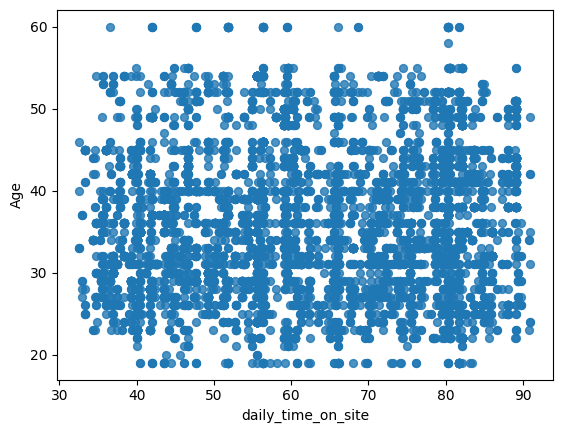

In [436]:
df.plot(kind='scatter', x='daily_time_on_site', y='Age', s=32, alpha=.8)

In [437]:
for col in df.columns:
  print(df[col].isna().sum())

0
0
0
0
0
0
0
0
0
0


In [438]:
df.columns

Index(['daily_time_on_site', 'Age', 'Area_Income', 'Daily_Internet_Usage',
       'Ad_Topic_Line', 'City', 'Gender', 'Country', 'Timestamp',
       'Clicked_on_Ad'],
      dtype='object')

## Getting number of unique elements in each columns

In [439]:
df.columns

Index(['daily_time_on_site', 'Age', 'Area_Income', 'Daily_Internet_Usage',
       'Ad_Topic_Line', 'City', 'Gender', 'Country', 'Timestamp',
       'Clicked_on_Ad'],
      dtype='object')

In [440]:
unique_elements = []
for col in sparse_features:
  unique_elements.append((col, df[col].nunique()))
unique_elements

[('Ad_Topic_Line', 559), ('City', 521), ('Gender', 2), ('Country', 207)]

In [441]:
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from deepctr.models import *
import deepctr

### Checking the shapes of the Series of each columns

In [442]:
for col in numerical_features:
  print(df[col].shape)

(10000,)
(10000,)
(10000,)
(10000,)


In [443]:
# giving each unique feature a label for easier differentiation

# 1. Label Encoding: storing the label encoders for output comparison
label_encoders = {}
for feature in sparse_features:
  lbe = LabelEncoder()
  df[feature] = lbe.fit_transform(df[feature])
  label_encoders[feature] = lbe

# 2. Standard Scaling for Numerical Features
scalers = {}
for feature in numerical_features:
  scaler = sklearn.preprocessing.StandardScaler()
  df[feature] = scaler.fit_transform(df[feature].values.reshape(-1, 1))
  scalers[feature] = scaler


In [444]:
df.head(2)

,daily_time_on_site,Age,Area_Income,Daily_Internet_Usage,Ad_Topic_Line,City,Gender,Country,Timestamp,Clicked_on_Ad
0,0.038160,-0.459619,1.172282,-0.120773,96,234,1,174,2016-06-09 21:43:05,0
1,-1.269204,-0.576270,0.599579,0.720504,301,460,1,166,2016-01-16 17:56:05,0


In [445]:
fixed_length_feature_columns = [deepctr.feature_column.SparseFeat(feature, df[feature].max() + 1, embedding_dim=6) for feature in sparse_features]

#adding numerical features to above feature columns
fixed_length_feature_columns += [deepctr.feature_column.DenseFeat(feature, 1) for feature in numerical_features]

linear_feature_columns = fixed_length_feature_columns
dnn_feature_columns = fixed_length_feature_columns
fixed_length_feature_columns

[SparseFeat(name='Ad_Topic_Line', vocabulary_size=559, embedding_dim=6, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x792aebb378b0>, embedding_name='Ad_Topic_Line', group_name='default_group', trainable=True),
 SparseFeat(name='City', vocabulary_size=521, embedding_dim=6, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x792aebe6c220>, embedding_name='City', group_name='default_group', trainable=True),
 SparseFeat(name='Gender', vocabulary_size=2, embedding_dim=6, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x792aebef1db0>, embedding_name='Gender', group_name='default_group', trainable=True),
 SparseFeat(name='Country', vocabulary_size=207, embedding_dim=6, use_hash=Fa

In [446]:
feature_names = deepctr.feature_column.get_feature_names(fixed_length_feature_columns+dnn_feature_columns)

In [447]:
train, test = train_test_split(df, test_size=0.2)
train.shape, test.shape

((8000, 10), (2000, 10))

In [448]:
from itertools import islice

def take(iterables, n):
  return list(islice(iterables, n))

In [449]:
train_model_input ={name:train[name].values for name in feature_names}
test_model_input ={name:test[name].values for name in feature_names}
type(train_model_input),type( test_model_input), take(train_model_input, 1), take(test_model_input, 1)

(dict, dict, ['Ad_Topic_Line'], ['Ad_Topic_Line'])

In [450]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')
model.compile('adam','mse', metrics=['mse', 'accuracy'])

In [451]:
history = model.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=20, verbose=2, validation_split=0.2, )

Epoch 1/20
25/25 - 3s - loss: 0.9421 - mse: 0.9421 - accuracy: 0.5666 - val_loss: 0.2361 - val_mse: 0.2360 - val_accuracy: 0.6544
Epoch 2/20
25/25 - 0s - loss: 0.1756 - mse: 0.1756 - accuracy: 0.7423 - val_loss: 0.1367 - val_mse: 0.1367 - val_accuracy: 0.8150
Epoch 3/20
25/25 - 0s - loss: 0.0982 - mse: 0.0982 - accuracy: 0.8763 - val_loss: 0.1037 - val_mse: 0.1036 - val_accuracy: 0.8687
Epoch 4/20
25/25 - 0s - loss: 0.0780 - mse: 0.0780 - accuracy: 0.9077 - val_loss: 0.1017 - val_mse: 0.1017 - val_accuracy: 0.8750
Epoch 5/20
25/25 - 0s - loss: 0.0728 - mse: 0.0728 - accuracy: 0.9152 - val_loss: 0.1025 - val_mse: 0.1024 - val_accuracy: 0.8644
Epoch 6/20
25/25 - 0s - loss: 0.0683 - mse: 0.0683 - accuracy: 0.9212 - val_loss: 0.1035 - val_mse: 0.1034 - val_accuracy: 0.8662
Epoch 7/20
25/25 - 0s - loss: 0.0663 - mse: 0.0662 - accuracy: 0.9262 - val_loss: 0.1059 - val_mse: 0.1058 - val_accuracy: 0.8625
Epoch 8/20
25/25 - 0s - loss: 0.0652 - mse: 0.0652 - accuracy: 0.9273 - val_loss: 0.1064 -

In [452]:
pred_ans = model.predict(test_model_input, batch_size=256)
print("test MSE", round(sklearn.metrics.mean_squared_error(test[target].values, pred_ans), 4))

test MSE 0.1153


In [453]:
# Extract values
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

<ipython-input-454-2c26b5a304db>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b-', label='Training loss', color='blue')
<ipython-input-454-2c26b5a304db>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r--', label='Validation loss', color='lightcoral')
<ipython-input-454-2c26b5a304db>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, accuracy, 'b-', label='Training accuracy', color='darkblue')
<ipython-input-454-2c26b5a304db>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precede

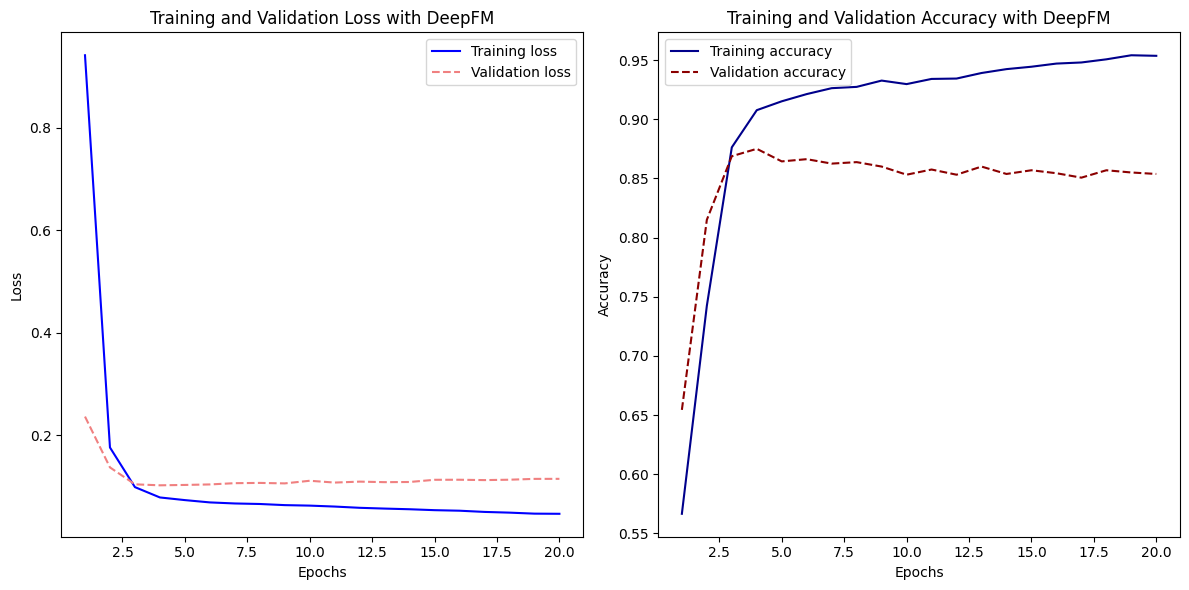

In [454]:

# Plotting the Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training loss', color='blue')
plt.plot(epochs, val_loss, 'r--', label='Validation loss', color='lightcoral')
plt.title('Training and Validation Loss with DeepFM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'b-', label='Training accuracy', color='darkblue')
plt.plot(epochs, val_accuracy, 'r--', label='Validation accuracy', color='darkred')
plt.title('Training and Validation Accuracy with DeepFM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Checking the predicted advertisement clicks with random data

## with Dense Feat for numerical features

Epoch 20/20
25/25 - 0s - loss: 0.0509 - mse: 0.0507 - accuracy: 0.9459 - val_loss: 0.1059 - val_mse: 0.1058 - val_accuracy: 0.8694

In [455]:
df.head(1)

,daily_time_on_site,Age,Area_Income,Daily_Internet_Usage,Ad_Topic_Line,City,Gender,Country,Timestamp,Clicked_on_Ad
0,0.03816,-0.459619,1.172282,-0.120773,96,234,1,174,2016-06-09 21:43:05,0


In [456]:
df_org['Ad Topic Line'].astype(str)

0              Decentralized real-time circuit
1               Optional full-range projection
2          Total 5thgeneration standardization
3                  Balanced empowering success
4          Total 5thgeneration standardization
                         ...                  
9995            Profound executive flexibility
9996            Managed zero tolerance concept
9997            Intuitive exuding service-desk
9998          Realigned content-based leverage
9999    Optimized upward-trending productivity
Name: Ad Topic Line, Length: 10000, dtype: object

In [457]:
df_org['Ad Topic Line'].unique().tolist()[:5]
# df_org['Country'].unique().tolist()[:5]
# df_org['Area Income'].unique().tolist()[:5]


['Decentralized real-time circuit',
 'Optional full-range projection',
 'Total 5thgeneration standardization',
 'Balanced empowering success',
 'Focused multi-state workforce']

In [458]:
type(df_org['Age'])

pandas.core.series.Series

In [459]:
user_input = pd.Series({
  'daily_time_on_site': 120,
  'Age': 26,
  'Area_Income': 50000,
  'Daily_Internet_Usage': 150,
  'Ad_Topic_Line': 'Decentralized real-time circuit',
  'City': 'West Richard',
  'Gender':'Male',
  'Country':'Singapore'
})
user_input

daily_time_on_site                                  120
Age                                                  26
Area_Income                                       50000
Daily_Internet_Usage                                150
Ad_Topic_Line           Decentralized real-time circuit
City                                       West Richard
Gender                                             Male
Country                                       Singapore
dtype: object

In [460]:
label_encoders['Gender'].transform(['Female'])

array([0])

In [461]:
scalers['daily_time_on_site'].transform([[1000]])

array([[59.75405516]])

In [462]:
for feature in sparse_features:
  user_input[feature] = label_encoders[feature].transform([user_input[feature]])

In [467]:
for feature in numerical_features:
  print(feature)
  user_input[feature] = scalers[feature].transform(np.array(user_input[feature]).reshape(-1, 1))

# preparing user inputs to the model
user_input_model = {name:[user_input[name]] for name in feature_names}
user_input_model

daily_time_on_site
Age
Area_Income
Daily_Internet_Usage


{'Ad_Topic_Line': [array(96)],
 'City': [array(495)],
 'Gender': [array(1)],
 'Country': [array(166)],
 'daily_time_on_site': [array([[3.71508105]])],
 'Age': [array([[-1.15952743]])],
 'Area_Income': [array([[-0.28779403]])],
 'Daily_Internet_Usage': [array([[-0.68007281]])]}

In [468]:
train_model_input, user_input_model

({'Ad_Topic_Line': array([186, 258, 348, ..., 153, 426, 444]),
  'City': array([136, 473, 506, ..., 517, 112, 136]),
  'Gender': array([0, 0, 0, ..., 1, 0, 0]),
  'Country': array([ 44,  14,  44, ..., 146, 178, 205]),
  'daily_time_on_site': array([-0.05990802, -0.95844202, -0.38595296, ..., -0.88648289,
         -1.36854543, -1.6589292 ]),
  'Age': array([-1.50948189, -1.15952743,  2.10671416, ...,  0.47359337,
          1.05685079, -0.92622446]),
  'Area_Income': array([ 0.09605024,  0.21389968,  0.29723225, ...,  0.12438261,
          0.45315997, -0.0585427 ]),
  'Daily_Internet_Usage': array([-0.12126318,  0.06639494, -0.38413154, ..., -0.47379587,
         -1.30061853, -0.12126318])},
 {'Ad_Topic_Line': [array(96)],
  'City': [array(495)],
  'Gender': [array(1)],
  'Country': [array(166)],
  'daily_time_on_site': [array([[3.71508105]])],
  'Age': [array([[-1.15952743]])],
  'Area_Income': [array([[-0.28779403]])],
  'Daily_Internet_Usage': [array([[-0.68007281]])]})

### Error in inference shapes

In [469]:
# Predict the rating
predicted_rating = model.predict(user_input_model)
print("Predicted rating:", predicted_rating[0][0])

IndexError: list index out of range